In [1]:
# ============================================================
# Step 1: Import library
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import skew
from xgboost import XGBRegressor # Included here for convenience

## 💾 Step 2: Load and Initial Exploration

In [2]:
# ============================================================
# Step 2: --- Load datasets ---
# ============================================================
train = pd.read_csv("/home/hardik/Desktop/python_intern/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/home/hardik/Desktop/python_intern/house-prices-advanced-regression-techniques/test.csv")

print("✅ Data loaded successfully!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# --- Explore data ---
print("\n📊 Train Data Info:")
print(train.info())

print("\n🧾 Summary Statistics:")
print(train.describe())

✅ Data loaded successfully!
Train shape: (1460, 81)
Test shape: (1459, 80)

📊 Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  H


🔍 Missing Values in Train Data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64


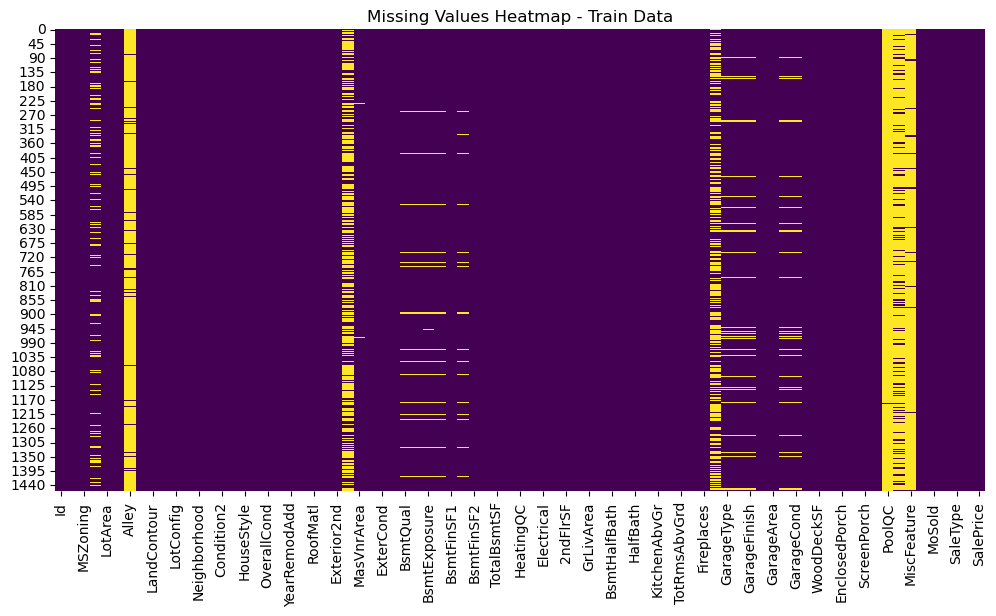

In [3]:
# --- Check and Visualize Missing Data ---
print("\n🔍 Missing Values in Train Data:")
print(train.isnull().sum().sort_values(ascending=False).head(10))

plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap - Train Data")
plt.show()

## 🛠️ Step 3-10: Preprocessing and Feature Engineering

In [4]:
# ============================================================
# Step 3: Log-transform target variable (SalePrice)
# ============================================================
train["SalePrice"] = np.log1p(train["SalePrice"])  # log(1 + y)
y = train["SalePrice"]

# Combine train and test for consistent preprocessing
all_data = pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1))).reset_index(drop=True)
print("Combined data shape:", all_data.shape)

Combined data shape: (2919, 79)


In [5]:
# ============================================================
# Step 4: Handle Missing Values
# ============================================================

# Fill NA with 'None' for categorical columns that mean "No feature"
for col in [
    'PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType',
    'GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond',
    'BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType'
]:
    all_data[col] = all_data[col].fillna('None')

# Fill 0 for numerical features with no basement/garage/etc.
for col in [
    'GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
    'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea'
]:
    all_data[col] = all_data[col].fillna(0)

# LotFrontage: fill with median of each neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Fill remaining categorical features with mode
for col in [
    'MSZoning','Functional','Utilities','Exterior1st','Exterior2nd',
    'KitchenQual','SaleType','Electrical'
]:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Drop Utilities (no variance)
all_data = all_data.drop(['Utilities'], axis=1)

print("Missing values handled and 'Utilities' dropped.")

Missing values handled and 'Utilities' dropped.


In [6]:
# ============================================================
# Step 5: Convert Some Numeric Columns to String (Categorical)
# ============================================================
for col in ['MSSubClass','OverallCond','YrSold','MoSold']:
    all_data[col] = all_data[col].astype(str)


# ============================================================
# Step 6: Label Encoding for Ordered Categories
# ============================================================
cols = (
    'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
    'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC',
    'BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','Fence'
)
for c in cols:
    lbl = LabelEncoder()
    all_data[c] = lbl.fit_transform(all_data[c])

print("Categorical features converted/label encoded.")

Categorical features converted/label encoded.


In [7]:
# ============================================================
# Step 7: Add New Feature
# ============================================================
all_data['TotalSF'] = (
    all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
)
print("'TotalSF' feature added.")

'TotalSF' feature added.


In [8]:
# ============================================================
# Step 8: Fix Skewness in Numeric Features
# ============================================================
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features = skewed_feats[abs(skewed_feats) > 0.75].index
all_data[skewed_features] = np.log1p(all_data[skewed_features])
print(f"{len(skewed_features)} numerical features were log-transformed to reduce skewness.")

34 numerical features were log-transformed to reduce skewness.


In [9]:
# ============================================================
# Step 9: One-Hot Encoding
# ============================================================
all_data = pd.get_dummies(all_data)
print("Data shape after one-hot encoding:", all_data.shape)

Data shape after one-hot encoding: (2919, 273)


In [10]:
# ============================================================
# Step 10: Split Back into Train/Test
# ============================================================
X_train = all_data[:len(train)]
X_test = all_data[len(train):]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1460, 273)
X_test shape: (1459, 273)


## 🤖 Step 11-13: Model Training, Evaluation, and Prediction

In [11]:
# ============================================================
# Step 11: Train XGBoost Model
# ============================================================

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

print("Starting XGBoost training...")
xgb_model.fit(X_train, y)
print("XGBoost training complete.")

Starting XGBoost training...
XGBoost training complete.


In [12]:
# ============================================================
# Step 12: Evaluate Model (on Training Data)
# ============================================================
y_pred = xgb_model.predict(X_train)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("XGBoost Performance on Training Data (Log-transformed):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

XGBoost Performance on Training Data (Log-transformed):
MAE  : 0.0155
RMSE : 0.0203
R²   : 0.9974


In [13]:
# ============================================================
# Step 13: Predict on Test Data (Convert Back from log)
# ============================================================
preds = np.expm1(xgb_model.predict(X_test))
print("✅ Prediction completed! Sample output (Actual Prices):")
print(preds[:10])

✅ Prediction completed! Sample output (Actual Prices):
[128051.76 167790.52 190267.73 192078.33 182625.45 173498.6  175175.33
 172061.58 179826.67 124444.2 ]


In [15]:
import pickle

# Save the model
out_path = r'/home/hardik/Desktop/python_intern/house_price.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(xgb_model, f)
print("✅ Model saved successfully at:", out_path)

# Load it back later
with open(out_path, 'rb') as f:
    loaded_model = pickle.load(f)

✅ Model saved successfully at: /home/hardik/Desktop/python_intern/house_price.pkl
